# Preprocessing

Before starting the analysis part of the project, a little preprocessing has to be done. To start, we create a list with all the stories in it. Next we take apart each token to save only the lemmatized token, and remove unnecessary tokens (such as "/n" or punctuation). 

In [5]:
import os
import glob

# appends to file_list all files inside the particular folder given below that end with ".txt"
file_list = []
for file_name in glob.iglob("data/**/*.txt", recursive=True):
    file_list.append(file_name)

# appends each line of each story to story_list
story_list = []
for file in file_list:
    with open(file, "r", encoding='UTF-8') as story:
        lines = story.readlines()
        story_list.append(lines)  

In [6]:
file_list[:5]

['data\\cluster004\\102664476-Hansel-and-Grethel-Brothers-Grimm.txt',
 'data\\cluster004\\143982037-The-Singing-Springing-Lark-Brothers-Grimm.txt',
 'data\\cluster004\\265219660-The-Drummer-Brothers-Grimm.txt',
 'data\\cluster004\\341302702-Iron-John-Brothers-Grimm.txt',
 'data\\cluster004\\382576826-Strong-Hans-Brothers-Grimm.txt']

In [7]:
story_list[0][:10]

['<title>/NNP --> NNP/NNP\n',
 '15/CD --> 15/CD\n',
 'Hansel/NNP --> Hansel/NNP\n',
 'and/CC --> and/CC\n',
 'Grethel/NNP --> Grethel/NNP\n',
 '</title>/NNP --> NNP/NNP\n',
 '<author>/NNP --> NNP/NNP\n',
 'Brothers/NNPS --> Brothers/NNPS\n',
 'Grimm/NNP --> Grimm/NNP\n',
 '</author>/NNP --> NNP/NNP\n']

In [8]:
# removes the first, not letmmatized, instance of each token, and lowercase everything
trimmed_story_list = []
for sentence in story_list:
    for token in sentence:
        if "-->" in token:
            split_token = token.split("-->", 1)[1]
            split_token = split_token.lower()
            trimmed_story_list.append(split_token)
        else:
            continue

In [9]:
trimmed_story_list[0]

' nnp/nnp\n'

In [10]:
# removes "/n" from the end of each token
cleaned_list = []
for item in trimmed_story_list:
    new_item = item[:-1]
    cleaned_list.append(new_item)

In [11]:
cleaned_list[:10]

[' nnp/nnp',
 ' 15/cd',
 ' hansel/nnp',
 ' and/cc',
 ' grethel/nnp',
 ' nnp/nnp',
 ' nnp/nnp',
 ' brothers/nnps',
 ' grimm/nnp',
 ' nnp/nnp']

In [12]:
# adds only relevant tokens to filtered_list: removes tokens that are not a word, as well as words irrelevant to our 
# study (such as determinants)
filtered_list=[]
for item in cleaned_list:
    if item.startswith((" .", " ,", " /", " :", " ;", " '", " `", " nnp", " ?", " !", " -", " 1", " 2"\
                       " 3", " 4", " 5", " 6", " 7", " 8", " 9", " 0")): 
        continue
    elif item.endswith(("cc", "in", "dt")):
        continue
    else:
        filtered_list.append(item.lstrip())

In [13]:
filtered_list[:10]

['hansel/nnp',
 'grethel/nnp',
 'brothers/nnps',
 'grimm/nnp',
 'hard/nnp',
 'great/jj',
 'forest/nn',
 'dwell/vbd',
 'poor/jj',
 'wood-cutter/nn']

# Data Exploration

Now we can move on the explore the data. To do so, we'll take a look at the stories themselves and what we can tell from the data before training any model on it.

We start by looking at the most frequent and least frequent words. 

In [14]:
from nltk.probability import FreqDist
frequency_dist = FreqDist(filtered_list)
frequency_dist.most_common(5)

[('he/prp', 220124),
 ('to/to', 217260),
 ('be/vbd', 140870),
 ('i/prp', 137579),
 ('she/prp', 99800)]

In [15]:
frequency_dist.most_common()[-5:]

[('straw/vbd', 1),
 ('stranger/vbz', 1),
 ('door-step/nn', 1),
 ('kitchen-sink/jj', 1),
 ('whet/vbz', 1)]

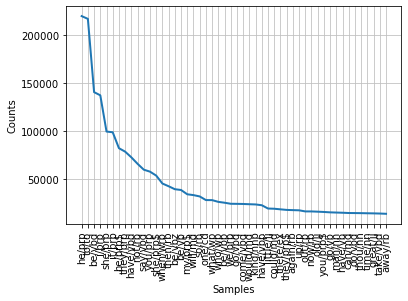

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [16]:
frequency_dist.plot(50)

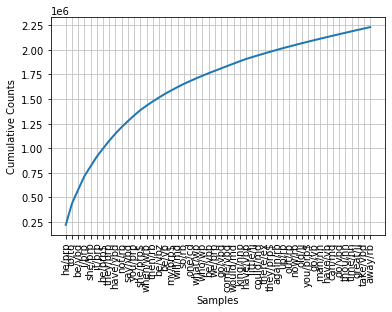

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [17]:
frequency_dist.plot(50, cumulative=True)

Now we can see a few things already. First of all, the most common words still contain stopwords, which will need to be removed to look only at usefull content. Based on the graphs, the stories also follow Zipf's law.

In [18]:
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

In [19]:
filtered_sentence = []
for token in filtered_list:
    check = token.split("/")[0]
    if not check in stop_words:
        filtered_sentence.append(check)

In [20]:
filtered_sentence[:10]

['hansel',
 'grethel',
 'brothers',
 'grimm',
 'hard',
 'great',
 'forest',
 'dwell',
 'poor',
 'wood-cutter']

Now that all stopwords have been removed, let's take another look at the frequency distribution

In [21]:
frequency_dist_nostop = FreqDist(filtered_sentence)
frequency_dist_nostop.most_common(10)

[('say', 68639),
 ('go', 48576),
 ('come', 41401),
 ('one', 33532),
 ('king', 30153),
 ('see', 29999),
 ('take', 28773),
 ('thou', 25255),
 ('would', 24053),
 ('give', 22250)]

In [22]:
frequency_dist_nostop.most_common()[-5:]

[('laziest', 1),
 ('negligent', 1),
 ('eneke', 1),
 ('beneke', 1),
 ('door-step', 1)]

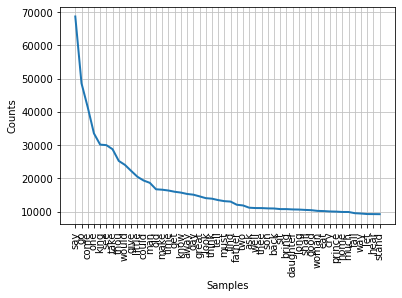

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [23]:
frequency_dist_nostop.plot(50)

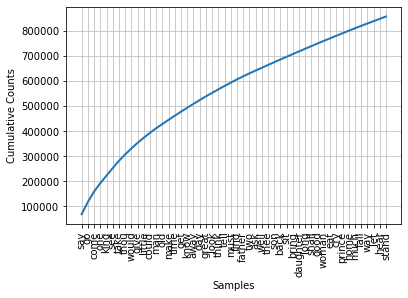

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [24]:
frequency_dist_nostop.plot(50, cumulative=True)

Zipf's law seems like it is still in place. When we look at the top 10 words we can already see something interesting. For example, the word "say" is used most often. If you think about fairy tales this makes sense; most sentences are in the form of "blablabla said the pricess". Lemmatized this is then "say". The other interesting token is "king". Since this token is associated with a specific gender/sex, and is used so often, we can expect that there are certain words associated with this token. 

# Building n-grams

As part of our research, we are using an n-gram model for sentence generation and hope to find that the model is perhaps biased or not. To do so, some code was borrowed and adapted from: https://github.com/olegborisovv/NGram_LanguageModel



In [25]:
test = filtered_sentence[:5]
test

['hansel', 'grethel', 'brothers', 'grimm', 'hard']

In [26]:
def get_ngrams(n, tokens):
    """
    :param n: n-gram size
    :param tokens: tokenized sentence
    :return: list of ngrams
    ngrams of tuple form: ((previous wordS!), target word)
    """
    tokens = (n-1)*['<START>']+tokens
    l = [(tuple([tokens[i-p-1] for p in reversed(range(n-1))]), tokens[i]) for i in range(n-1, len(tokens))]
    return l

In [27]:
get_ngrams(3, test)

[(('<START>', '<START>'), 'hansel'),
 (('<START>', 'hansel'), 'grethel'),
 (('hansel', 'grethel'), 'brothers'),
 (('grethel', 'brothers'), 'grimm'),
 (('brothers', 'grimm'), 'hard')]

I quickly tested the funtion above to see if it indeed works as it is supposed to. 

For this part of the assignment, an additional dataset was used; the anderongrimm.txt file in the repositor contains stories of Anderson and Grimm and is not preprocessed. 

In [28]:
import string
import random
import time
from typing import List

# ideally we would use some smart text tokenizer, but for simplicity use this one
def tokenize(text: str) -> List[str]:
    """
    :param text: Takes input sentence
    :return: tokenized sentence
    """
    for punct in string.punctuation:
        text = text.replace(punct, ' '+punct+' ')
    t = text.split()
    return t

def get_ngrams(n: int, tokens: list) -> list:
    """
    :param n: n-gram size
    :param tokens: tokenized sentence
    :return: list of ngrams
    ngrams of tuple form: ((previous wordS!), target word)
    """
    # tokens.append('<END>')
    tokens = (n-1)*['<START>']+tokens
    l = [(tuple([tokens[i-p-1] for p in reversed(range(n-1))]), tokens[i]) for i in range(n-1, len(tokens))]
    return l


class NgramModel(object):

    def __init__(self, n):
        self.n = n

        # dictionary that keeps list of candidate words given context
        self.context = {}

        # keeps track of how many times ngram has appeared in the text before
        self.ngram_counter = {}

    def update(self, sentence: str) -> None:
        """
        Updates Language Model
        :param sentence: input text
        """
        n = self.n
        ngrams = get_ngrams(n, tokenize(sentence))
        for ngram in ngrams:
            if ngram in self.ngram_counter:
                self.ngram_counter[ngram] += 1.0
            else:
                self.ngram_counter[ngram] = 1.0

            prev_words, target_word = ngram
            if prev_words in self.context:
                self.context[prev_words].append(target_word)
            else:
                self.context[prev_words] = [target_word]

    def prob(self, context, token):
        """
        Calculates probability of a candidate token to be generated given a context
        :return: conditional probability
        """
        try:
            count_of_token = self.ngram_counter[(context, token)]
            count_of_context = float(len(self.context[context]))
            result = count_of_token / count_of_context

        except KeyError:
            result = 0.0
        return result

    def random_token(self, context):
        """
        Given a context we "semi-randomly" select the next word to append in a sequence
        :param context:
        :return:
        """
        r = random.random()
        map_to_probs = {}
        token_of_interest = self.context[context]
        for token in token_of_interest:
            map_to_probs[token] = self.prob(context, token)

        summ = 0
        for token in sorted(map_to_probs):
            summ += map_to_probs[token]
            if summ > r:
                return token

    def generate_text(self, token_count: int):
        """
        :param token_count: number of words to be produced
        :return: generated text
        """
        n = self.n
        context_queue = (n - 1) * ['<START>']
        result = []
        for _ in range(token_count):
            obj = self.random_token(tuple(context_queue))
            result.append(obj)
            if n > 1:
                context_queue.pop(0)
                if obj == '.':
                    context_queue = (n - 1) * ['<START>']
                else:
                    context_queue.append(obj)
        return ' '.join(result)


def create_ngram_model(n, path):
    m = NgramModel(n)
    with open(path, 'r', encoding="latin-1") as f:
        text = f.read()
        text = text.split('.')
        for sentence in text:
            # add back the fullstop
            sentence += '.'
            m.update(sentence)
    return m

if __name__ == "__main__":
    for n in range(8):
        start = time.time()
        m = create_ngram_model(8, 'andersongrimm.txt')
        #print(f'n = {n}')
        #print (f'Language Model creating time: {time.time() - start}')
        start = time.time()
        random.seed(n)
        #print('Generated text:')
        print(m.generate_text(200))
        print(f'{"="*50}')

Then the king ' s son waited till her father came home , and told him that the unknown maiden who had been at the feast had hidden herself in the pigeon - house . " That is the tune I know , " she exclaimed . Jurgen did not understand the reason of this , but he thought it would be best to turn back , and therefore he himself took an oar and returned . They were telling each other where they had been during the day . Yes , he must be there . " Oh , now I have no horse at all , " said Little Claus , weeping . It was , in this transformation , as if two natures were striving together within her ; her whole frame trembled , and she looked around her as if she had just awoke from a painful dream . Sleep was still in his eyes , but yet he crowed out : " Three hens have died of their unfortunate love for a cock . With the rod knock thrice at the iron door of the castle , and it will spring open . She bent
" They say at home , " said the little boy , taking it up and looking at it . " Just th

As can be seen, the model is able to generate some texts, which do have some biases in them; "at home the beautiful wife prayed...."

# Showing frequent bigrams

Now we'll look at some bigrams and see if there are some obvious biases associated with gender. The code to generate the graph below is from: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [30]:
# Create list of lists containing bigrams our processed list of stories
terms_bigram = list(bigrams(filtered_sentence))
terms_bigram[0:10]

[('hansel', 'grethel'),
 ('grethel', 'brothers'),
 ('brothers', 'grimm'),
 ('grimm', 'hard'),
 ('hard', 'great'),
 ('great', 'forest'),
 ('forest', 'dwell'),
 ('dwell', 'poor'),
 ('poor', 'wood-cutter'),
 ('wood-cutter', 'wife')]

In [31]:
# Create counter of words in bigrams
bigram_counts = collections.Counter(terms_bigram)

bigram_counts.most_common(20)

[(('old', 'woman'), 5115),
 (('king', 'son'), 4249),
 (('king', 'daughter'), 3504),
 (('go', 'away'), 3315),
 (('thou', 'hast'), 3149),
 (('old', 'man'), 2958),
 (('thou', 'art'), 2710),
 (('brother', 'lustig'), 2418),
 (('thou', 'wilt'), 2289),
 (('one', 'day'), 2272),
 (('next', 'morning'), 2248),
 (('come', 'back'), 2215),
 (('brothers', 'grimm'), 2169),
 (('say', 'thou'), 2089),
 (('thou', 'shalt'), 2074),
 (('go', 'home'), 2033),
 (('st.', 'peter'), 2017),
 (('ev', 'ry'), 1999),
 (('long', 'time'), 1949),
 (('thou', 'must'), 1743)]

In [32]:
bigram_df = pd.DataFrame(bigram_counts.most_common(200),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(old, woman)",5115
1,"(king, son)",4249
2,"(king, daughter)",3504
3,"(go, away)",3315
4,"(thou, hast)",3149
...,...,...
195,"(nothing, say)",433
196,"(light, fire)",432
197,"(many, year)",432
198,"(say, wife)",431


In [33]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

In [34]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))


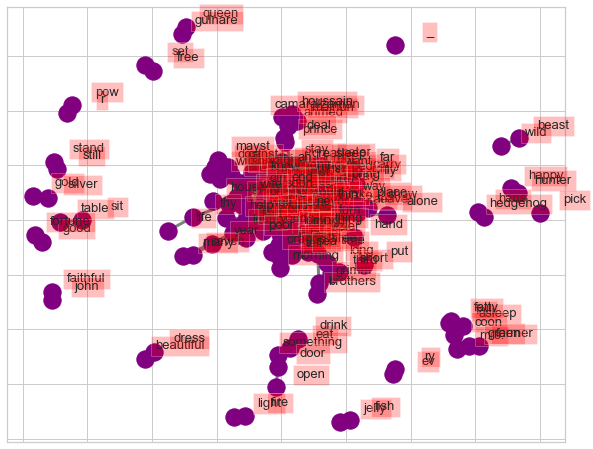

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

In [36]:
def select_bigrams(bigrams_list, token_list):
    selected_bigrams = []
    for tup in bigrams_list:
        for token in token_list:
            if token in tup:
                selected_bigrams.append(tup)
    return selected_bigrams

In [37]:
token_list = ["wife", "husband", "son", "daughter", "king", "queen", "prince", "princess", "brother", "sister", "mother", "father", "woman", "man", "lady", "gentleman", "gentlemen", "maiden", "girl", "boy"]
token_list_male = ["husband", "son", "king", "prince", "brother", "father", "man", "gentleman", "gentlemen", "bachelor", "boy"]
token_list_female = ["wife", "daughter", "queen", "princess", "sister", "mother", "woman", "lady", "maiden", "girl"]

In [38]:
selection_full = select_bigrams(terms_bigram, token_list)
selection_female = select_bigrams(terms_bigram, token_list_female)
selection_male = select_bigrams(terms_bigram, token_list_male)

In [39]:
selection_female[:20]

[('wood-cutter', 'wife'),
 ('wife', 'two'),
 ('hansel', 'girl'),
 ('girl', 'grethel'),
 ('say', 'wife'),
 ('wife', 'become'),
 ('answer', 'woman'),
 ('woman', 'early'),
 ('rid', 'wife'),
 ('wife', 'say'),
 ('little', 'sister'),
 ('sister', 'sleep'),
 ('rise', 'woman'),
 ('woman', 'come'),
 ('good-bye', 'wife'),
 ('wife', 'say'),
 ('high', 'woman'),
 ('woman', 'say'),
 ('little', 'sister'),
 ('sister', 'hand')]

In [40]:
selection_male[:20]

[('child', 'boy'),
 ('boy', 'call'),
 ('tell', 'husband'),
 ('husband', 'answer'),
 ('say', 'man'),
 ('man', 'bear'),
 ('say', 'man'),
 ('man', 'two'),
 ('say', 'father'),
 ('father', 'grethel'),
 ('house', 'father'),
 ('father', 'say'),
 ('ah', 'father'),
 ('father', 'say'),
 ('forest', 'father'),
 ('father', 'say'),
 ('believe', 'father'),
 ('father', 'however'),
 ('come', 'father'),
 ('father', 'house')]

In [41]:
counts = collections.Counter(selection_full)
counts.most_common(20)

[(('king', 'son'), 8498),
 (('king', 'daughter'), 7008),
 (('old', 'woman'), 5115),
 (('old', 'man'), 2958),
 (('brother', 'lustig'), 2418),
 (('say', 'king'), 1615),
 (('king', 'say'), 1598),
 (('father', 'mother'), 1192),
 (('say', 'father'), 1176),
 (('prince', 'ahmed'), 1111),
 (('king', 'persia'), 936),
 (('young', 'man'), 888),
 (('man', 'say'), 868),
 (('say', 'man'), 846),
 (('daughter', 'wife'), 770),
 (('king', 'queen'), 764),
 (('say', 'brother'), 728),
 (('queen', 'mother'), 722),
 (('king', 'father'), 704),
 (('king', 'beder'), 672)]

In [42]:
counts_female = collections.Counter(selection_female)
counts_female.most_common(20)

[(('old', 'woman'), 5115),
 (('king', 'daughter'), 3504),
 (('daughter', 'wife'), 770),
 (('queen', 'mother'), 722),
 (('mother', 'say'), 616),
 (('daughter', 'say'), 613),
 (('father', 'mother'), 596),
 (('woman', 'say'), 569),
 (('queen', 'gulnare'), 560),
 (('say', 'mother'), 494),
 (('woman', 'come'), 485),
 (('little', 'girl'), 484),
 (('say', 'girl'), 472),
 (('wife', 'say'), 436),
 (('say', 'wife'), 431),
 (('beautiful', 'maiden'), 409),
 (('king', 'queen'), 382),
 (('give', 'daughter'), 379),
 (('go', 'mother'), 363),
 (('say', 'maiden'), 362)]

In [43]:
counts_male = collections.Counter(selection_male)
counts_male.most_common(20)

[(('king', 'son'), 8498),
 (('king', 'daughter'), 3504),
 (('old', 'man'), 2958),
 (('brother', 'lustig'), 2418),
 (('say', 'king'), 1615),
 (('king', 'say'), 1598),
 (('say', 'father'), 1176),
 (('prince', 'ahmed'), 1111),
 (('king', 'persia'), 936),
 (('young', 'man'), 888),
 (('man', 'say'), 868),
 (('say', 'man'), 846),
 (('say', 'brother'), 728),
 (('king', 'father'), 704),
 (('king', 'beder'), 672),
 (('vizier', 'son'), 661),
 (('king', 'saleh'), 624),
 (('dragon', 'king'), 621),
 (('son', 'king'), 600),
 (('father', 'mother'), 596)]

Based on what we can see of the bigrams, there is not much bias to be found. Apparently it is common to have and old man or woman and an ill queen or king, but there is not much to say for strict biases. The only bigram that could be considered a bias is the "beautiful maidens". 

# Word Embeddings

To create word embeddings we will first look at the surface co-occurence counts between a target word and a contextual word, by counting how many times a contextual word occurs in a collocational span surrounding the target word, in a symmetric 5 word span. 

We will look at nouns, since these include the gendered nouns such as boy/girl or prince/princess and can shows us which words are most often used around them.

In [44]:
#We first make a list without the stopwords like in filtered_sentence, but with the PoS-tagging

filtered_words = []
for token in filtered_list:
    check = token.split("/")[0]
    if not check in stop_words:
        filtered_words.append(token)

In [45]:
filtered_words[:10]

['hansel/nnp',
 'grethel/nnp',
 'brothers/nnps',
 'grimm/nnp',
 'hard/nnp',
 'great/jj',
 'forest/nn',
 'dwell/vbd',
 'poor/jj',
 'wood-cutter/nn']

In [46]:
from itertools import permutations
from collections import Counter

spansize = 5

cooccs_surface = Counter()

for index, word in enumerate(filtered_words):
    if word.split("/")[-1][:2] == "nn":
        span_range = list(range(max(index- spansize, 0), index)) # left side indices (range, then list so we can extend)
        span_range.extend(range(index+1, min(index + spansize + 1, len(filtered_words)))) # extend by right side indices
        for cooc_word in [filtered_words[idx] for idx in span_range]:
            cooccs_surface[(word, cooc_word)] += 1        

In [47]:
cooccs_surface.most_common(10)

[(('king/nnp', 'say/vbd'), 7044),
 (('thou/nn', 'say/vbd'), 6609),
 (('woman/nn', 'old/jj'), 5623),
 (('king/nnp', 'son/nn'), 5108),
 (('son/nn', 'king/nnp'), 5108),
 (('king/nnp', 'daughter/nn'), 4938),
 (('daughter/nn', 'king/nnp'), 4938),
 (('man/nn', 'say/vbd'), 4629),
 (('thou/nn', 'thou/nn'), 4360),
 (('man/nn', 'old/jj'), 3800)]

Next we want to filter out some very infrequent contextual items, since they do not add relevant information and only slow down the computation. 

We do this by first making a frequency list of the words and then plot the frequencies on a logarithmic scale to decide which frequency threshold we shall use.

In [48]:
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt

words_frequencies = Counter(chain(filtered_words))
print(list(reversed(words_frequencies.most_common()))[:20])

[('whet/vbz', 1), ('kitchen-sink/jj', 1), ('door-step/nn', 1), ('stranger/vbz', 1), ('straw/vbd', 1), ('beneke/nnp', 1), ('eneke/nnp', 1), ('lambkin/nnp', 1), ('woo/vbn', 1), ('span/vbp', 1), ('negligent/jj', 1), ('porridge/nnp', 1), ('laziest/jjs', 1), ('sluggards/nnp', 1), ('interfere/vb', 1), ('subject/vbn', 1), ('hadi/nnp', 1), ('dom/nnp', 1), ('intoxicated/jj', 1), ('request/vbn', 1)]


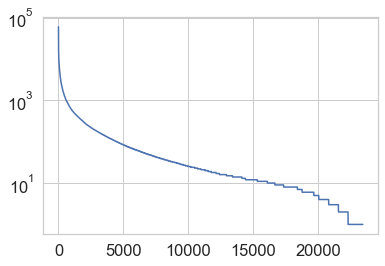

In [49]:
x = np.arange(1, len(words_frequencies) + 1)
y = np.array(sorted(words_frequencies.values(), reverse = True))

plt.plot(x, y)

plt.yscale('log') 

plt.show()

From this plot we decided to only use co-occurence words with a frequency of 10 or more.

We make a counter from these words and filter coocs_surface to only contain co-occurences with these words. We also remove these least frequent words from the nouns that we will look at since they also will not add any extra information.

In [50]:
filtered_cooc_frequencies = Counter()
selected_noun_frequencies = Counter()

for word, frequency in words_frequencies.items():
    pos = word.split("/")[-1]
    if frequency >= 10:
        filtered_cooc_frequencies[word] = frequency
        if pos[:2] == "nn":
            selected_noun_frequencies[word] = frequency

print(">>", len(filtered_cooc_frequencies), "context lemmas")
print(filtered_cooc_frequencies.most_common(20))

>> 16671 context lemmas
[('say/vbd', 60060), ('one/cd', 28382), ('go/vbd', 24434), ('come/vbd', 24318), ('would/md', 24053), ('king/nnp', 23820), ('little/jj', 19560), ('could/md', 19351), ('old/jj', 16286), ('go/vb', 15576), ('man/nn', 15372), ('thou/nn', 14754), ('time/nn', 14623), ('great/jj', 14513), ('take/vbd', 14343), ('away/rb', 14078), ('must/md', 13149), ('see/vbd', 12503), ('two/cd', 11884), ('father/nn', 11482)]


In [51]:
print(len(selected_noun_frequencies), "target nouns")

8183 target nouns


In [52]:
filtered_cooccs_surface = Counter()

for words, frequency in cooccs_surface.items():
    if words[0] in selected_noun_frequencies and words[1] in filtered_cooc_frequencies:
        filtered_cooccs_surface[words] = frequency

print(filtered_cooccs_surface.most_common(20))

[(('king/nnp', 'say/vbd'), 7044), (('thou/nn', 'say/vbd'), 6609), (('woman/nn', 'old/jj'), 5623), (('king/nnp', 'son/nn'), 5108), (('son/nn', 'king/nnp'), 5108), (('king/nnp', 'daughter/nn'), 4938), (('daughter/nn', 'king/nnp'), 4938), (('man/nn', 'say/vbd'), 4629), (('thou/nn', 'thou/nn'), 4360), (('man/nn', 'old/jj'), 3800), (('king/nnp', 'king/nnp'), 3382), (('father/nn', 'say/vbd'), 3191), (('day/nn', 'one/cd'), 3080), (('son/nn', 'say/vbd'), 3044), (('thee/nn', 'thee/nn'), 2788), (('woman/nn', 'say/vbd'), 2764), (('hast/nn', 'thou/nn'), 2749), (('thou/nn', 'hast/nn'), 2749), (('daughter/nn', 'say/vbd'), 2673), (('art/nn', 'thou/nn'), 2643)]


Below we made a function to print the 10 most co-occuring words for a given noun from our filtered_cooccs_surface, which we then tested on some general male and female words.

In [53]:
import heapq

def ten_most_cooccs(word):
    ten_most = []
    while len(ten_most) < 20:
        for words, frequency in filtered_cooccs_surface.items():
            if words[0].split("/")[0] == word: 
                ten_most.append((words[1].split("/")[0], frequency))
    if len(ten_most) == 0:
        print("This word is not in our texts")
    else:
        print("The ten most co-occuring words are: \n", heapq.nlargest(10,ten_most,key=lambda item:item[1]))

In [54]:
ten_most_cooccs("princess")

The ten most co-occuring words are: 
 [('say', 868), ('beautiful', 409), ('would', 403), ('badoura', 354), ('go', 327), ('daughter', 325), ('say', 320), ('prince', 317), ('king', 316), ('king', 283)]


In [55]:
ten_most_cooccs("prince")

The ten most co-occuring words are: 
 [('ahmed', 1409), ('say', 1027), ('prince', 802), ('say', 723), ('ali', 684), ('houssain', 637), ('majnun', 630), ('camaralzaman', 562), ('son', 509), ('king', 390)]


In [56]:
ten_most_cooccs("girl")

The ten most co-occuring words are: 
 [('say', 1609), ('little', 710), ('go', 537), ('old', 457), ('come', 433), ('one', 421), ('heart', 414), ('would', 408), ('must', 373), ('take', 372)]


In [57]:
ten_most_cooccs("woman")

The ten most co-occuring words are: 
 [('old', 5623), ('say', 2764), ('little', 751), ('come', 709), ('woman', 666), ('house', 635), ('one', 609), ('would', 600), ('man', 579), ('go', 567)]


In [58]:
ten_most_cooccs("man")

The ten most co-occuring words are: 
 [('say', 4629), ('old', 3800), ('one', 1238), ('come', 1193), ('go', 1086), ('ask', 1071), ('little', 1037), ('would', 997), ('go', 878), ('young', 848)]


In [59]:
ten_most_cooccs("boy")

The ten most co-occuring words are: 
 [('say', 999), ('little', 529), ('man', 324), ('boy', 284), ('go', 278), ('however', 246), ('could', 232), ('king', 231), ('come', 230), ('see', 229)]


In [60]:
ten_most_cooccs("king")

The ten most co-occuring words are: 
 [('say', 7044), ('son', 5108), ('daughter', 4938), ('king', 3382), ('come', 2484), ('go', 2344), ('would', 1658), ('great', 1580), ('take', 1557), ('go', 1503)]


In [61]:
ten_most_cooccs("queen")

The ten most co-occuring words are: 
 [('king', 1227), ('say', 803), ('gulnare', 632), ('go', 479), ('child', 410), ('young', 397), ('mother', 397), ('one', 376), ('little', 339), ('queen', 338)]


These most co-occuring words do not seem to give away any bias.

Now we will create vectors by populating a matrix of a ppmi-weighted co-occurence. First we will have to weight the co-occurences.

In [62]:
#this funtion is taken from notebook 4 of this course

from math import log

def ppmi(o_11, r_1, c_1, n):
    """
    Positive Pointwise Mutual Information (Church & Hanks, 1990)
    
    PMI is also available in NLTK:
    from nltk.metrics import BigramAssocMeasures
    print BigramAssocMeasures.pmi(8, (15828, 4675), 14307668)
    """
    observed = o_11
    expected = (r_1*c_1)/n 
    res = log(observed/expected,2)
    return max(0, res)

In [63]:
ppmis_surface = Counter()

N = sum(cooccs_surface.values())  # note that this is NOT the reduced dictionary

for words, frequency in filtered_cooccs_surface.items():
    ppmis_surface[words] = ppmi(frequency, words_frequencies[words[0]], words_frequencies[words[1]], N)
    
print(ppmis_surface.most_common(10))

[(('diddle/nn', 'dum/nn'), 21.041191100738835), (('dum/nn', 'diddle/nn'), 21.041191100738835), (('diddle/nn', 'diddle/nn'), 20.719263005851474), (('bargain/nns', 'christening-feast/nn'), 20.56725991240642), (('christening-feast/nn', 'bargain/nns'), 20.56725991240642), (('roast-meat/nn', 'drip/vb'), 20.56725991240642), (('birthday/nn', 'obi/nnp'), 20.56725991240642), (('obi/nnp', 'birthday/nn'), 20.56725991240642), (('jinricksha/nns', 'mode/nns'), 20.56725991240642), (('mode/nns', 'jinricksha/nns'), 20.56725991240642)]


In [64]:
sorted_vectors = sorted(selected_noun_frequencies)
vectors_indices = dict((v,i) for i,v in enumerate(sorted_vectors))
contexts_indices = dict((v,i) for i,v in enumerate(sorted(filtered_cooc_frequencies)))

In [65]:
# initialize the PPMI-Weighted matrix
ppmiMat = np.zeros((len(vectors_indices), len(contexts_indices)))

# populate the matrix
for pair, weight in ppmis_surface.items():
    ppmiMat[vectors_indices[pair[0]]][contexts_indices[pair[1]]] = weight

Then we use sklear to create a cosine similarity matrix.

In [66]:
import sklearn

ppmiSimMat = sklearn.metrics.pairwise.cosine_similarity(ppmiMat)

Then we use the similarity matrix to look at the ten most similar words for some words.

In [67]:
k = 20
target_idx = vectors_indices["queen/nn"]

In [68]:
print("according to the ppmi space:\n")

for idx in ppmiSimMat[target_idx,].argsort()[::-1][1:k+1]:
    print(sorted_vectors[idx], ppmiSimMat[target_idx, idx])

according to the ppmi space:

king/nn 0.32469410738986304
gulnare/nnp 0.30347174516105796
majesty/nn 0.2992458175618349
persia/nnp 0.293150293547289
beder/nnp 0.2848305926495871
princess/nn 0.2808474243764205
prince/nn 0.2759670893238817
prince/nnp 0.27296632757903505
king/nnp 0.272734026988651
queen/nnp 0.27201132598896155
mother/nn 0.2663918300416393
palace/nn 0.2646045668775824
son/nn 0.2617109454295757
nephew/nn 0.2538107523766025
daughter/nn 0.24942157082273445
man/nn 0.24888693134344975
wife/nn 0.24578876542776976
saleh/nnp 0.2440349821080502
father/nn 0.24403355880465874
sir/nnp 0.2435500523864431


# Gensim model

We will create a gensim Word2Vec model on our dataset in order to look at vector analogies. 

To train the gensim model we first need a list of sentences, which we will create in the same way as the list of words was created. 

In [69]:
#makes a list of sencentces 
story_sentences = []
for sentence in story_list:
    new_sentence = []
    for token in sentence:
        if "-->" in token:
            split_token = token.split("-->", 1)[1]
            split_token = split_token.lower()[1:-1]
            new_sentence.append(split_token)
        else:
            continue
    story_sentences.append(new_sentence)

In [70]:
story_sentences[0][:10]

['nnp/nnp',
 '15/cd',
 'hansel/nnp',
 'and/cc',
 'grethel/nnp',
 'nnp/nnp',
 'nnp/nnp',
 'brothers/nnps',
 'grimm/nnp',
 'nnp/nnp']

In [71]:
filtered_story_sentences=[]

for sentence in story_sentences:
    new_sentence = []
    for item in sentence:
        if item.startswith((".", ",", "/", ":", ";", "'", "`", "nnp", "?", "!", "-", "1", "2"\
                       "3", "4", "5", "6", "7", "8", "9", "0")): 
            continue
        elif item.endswith(("cc", "in", "dt")):
            continue
        else:
            new_sentence.append(item.split("/")[0])
    filtered_story_sentences.append(new_sentence)

In [72]:
filtered_story_sentences[0][:10]

['hansel',
 'grethel',
 'brothers',
 'grimm',
 'hard',
 'great',
 'forest',
 'dwell',
 'poor',
 'wood-cutter']

Now that we have created a list with sentences, we train the gensim model with the same kind of parameters as used before and standard parameters for the other ones.

In [95]:
import gensim.models

# Using params from Word2Vec_FastText_Comparison
params = {
    'size': 100, # dimension of embeddings
    'window': 5, # window -/+ before and after focus word
    'iter': 5, # number of iterations over the corpus
    'min_count': 20, # filter on words whose frequency is below this count
    'sg': 0, 
    'negative': 5, 
    'workers': 4, 
    'alpha': 0.05 # initial learning rate 
}
model = gensim.models.Word2Vec(sentences=filtered_story_sentences, **params)

We look at the most similar words to some male/female words here and see that this gives fairly expected results with some outliers being that "prince" has "afflict" in its similarity list and "princess" "handsomest", which are not nouns that describe a person.

In [96]:
model.wv.most_similar("prince")

[('punctually', 0.4813958704471588),
 ('princess', 0.42970985174179077),
 ('sultan', 0.42053961753845215),
 ('magician', 0.4164815843105316),
 ('daimio', 0.40679168701171875),
 ('afflict', 0.3943600058555603),
 ('majesty', 0.3937920928001404),
 ('carpet', 0.39274632930755615),
 ('morrow', 0.37171077728271484),
 ('raja', 0.3716825842857361)]

In [97]:
model.wv.most_similar("princess")

[('foster-daughter', 0.46373167634010315),
 ('prince', 0.42970985174179077),
 ('maimoune', 0.4285435974597931),
 ('handsomest', 0.4030042886734009),
 ('maiden', 0.39827820658683777),
 ('hana-saka-jijii', 0.3829805254936218),
 ('slave', 0.3660255968570709),
 ('she', 0.36377477645874023),
 ('fairy', 0.35967791080474854),
 ('bride', 0.35913771390914917)]

In [98]:
model.wv.most_similar("girl")

[('maiden', 0.5226953029632568),
 ('wood-cutter', 0.4272345006465912),
 ('man', 0.4171905815601349),
 ('broom-maker', 0.39693036675453186),
 ('hans', 0.38247936964035034),
 ('beggar', 0.37669339776039124),
 ('she', 0.36957883834838867),
 ('brahman', 0.3638770282268524),
 ('journeyman', 0.3582809269428253),
 ('fellow', 0.3487825393676758)]

In [99]:
model.wv.most_similar("boy")

[('child', 0.43530818819999695),
 ('dwarf', 0.38490191102027893),
 ('sister', 0.3524893522262573),
 ('daughter', 0.3321686387062073),
 ('girl', 0.3273962140083313),
 ('granddaughter', 0.3260761797428131),
 ('maker', 0.3117324113845825),
 ('son', 0.3069663643836975),
 ('good-day', 0.3061896562576294),
 ('ribby', 0.3011266887187958)]

In [100]:
model.wv.most_similar("man")

[('woman', 0.554276168346405),
 ('fellow', 0.5396716594696045),
 ('folk', 0.4548168182373047),
 ('pedler-woman', 0.4354737401008606),
 ('abdallah', 0.43381810188293457),
 ('sorceress', 0.42068570852279663),
 ('girl', 0.4171905815601349),
 ('people', 0.4127648174762726),
 ('witch', 0.40776634216308594),
 ('crone', 0.40442633628845215)]

In [101]:
model.wv.most_similar("woman")

[('man', 0.554276168346405),
 ('hag', 0.5426852703094482),
 ('pedler-woman', 0.5423367023468018),
 ('rinkrank', 0.5277589559555054),
 ('abdallah', 0.506737232208252),
 ('bedgown', 0.4671592116355896),
 ('aldobrandin', 0.46555188298225403),
 ('she', 0.4335838258266449),
 ('sorceress', 0.42399826645851135),
 ('decayed', 0.42363274097442627)]

In [102]:
model.wv.most_similar("queen")

[('persia', 0.4619181752204895),
 ('king', 0.4237041473388672),
 ('saleh', 0.4216860234737396),
 ('she', 0.4148014783859253),
 ('dissatisfy', 0.40862298011779785),
 ('maiden', 0.3918079733848572),
 ('nurse', 0.38846665620803833),
 ('marriage', 0.38012468814849854),
 ('beder', 0.3736423850059509),
 ('wedding', 0.3648466169834137)]

In [103]:
model.wv.most_similar("king")

[('eblis', 0.5113502740859985),
 ('vizier', 0.49735283851623535),
 ('raja', 0.47771722078323364),
 ('soothsayer', 0.4719911515712738),
 ('he', 0.46362993121147156),
 ('reginer', 0.4586072862148285),
 ('she', 0.4350511431694031),
 ('judgment', 0.43443140387535095),
 ('queen', 0.4237041473388672),
 ('adopt', 0.38798266649246216)]

Now we copy the analogy function from notebook 5 and try some vector analogies with typical male/female words and stereotypes.

In [82]:
#This function is taken from notebook 5

def analogy(x1, x2, x3):
    result = model.wv.most_similar(positive=[x1, x2], negative=[x3])
    return result[0][0]

In [115]:
analogy("king","woman","man")

'she'

In [132]:
analogy("smart","girl","boy")

'moral'

In [126]:
analogy("brave","mother","father")

'gracefully'

In [119]:
analogy("handsome","girl","boy")

'nun'

In [120]:
analogy("son","father","mother")

'daughter'

In [121]:
analogy("beautiful","son","daughter")

'lovely'

In [131]:
analogy("kind","queen","king")

'good'

In [123]:
analogy("strong", "sister", "brother")

'naughty'

We can see that some of these analogies are quite similar, such as a kind is to king as good is to queen. 

However some show quite great differences, like strong is to brother as naughty is to sister and brave is to father as gracefull is to mother.

Next we copied the function from lab 5 that creates a pca scatterplot and applied it on some adjectives and gendered nouns.

In [91]:
#This function is copied from lab 5

from sklearn.decomposition import PCA

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    # do PCA on the selected embeddings
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

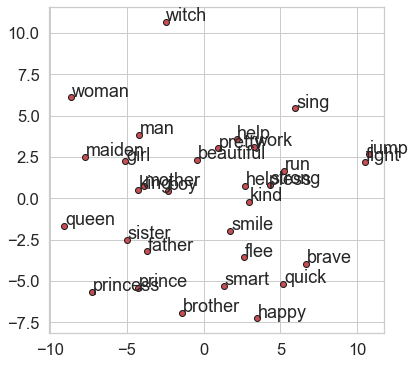

In [92]:
display_pca_scatterplot(model, 
                        ['prince', 'princess', 'king', 'queen', 'man', 'woman', 'girl', 'boy',
                         'father', 'mother', 'brother', 'sister', 'brave', 'kind', 'beautiful',
                         'strong', 'work', 'sing', 'smart', 'pretty', 'helpless', 'maiden',
                         'quick', 'happy', 'witch', 'jump', 'run', 'fight', 'smile', 'help', 'flee'])

plt.savefig("PCA_ScatterPlot", bbox_inches = 'tight')